## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
import numpy as np

a = np.arange(50000)
np.random.shuffle(a)
indexs = a[:5000]

x_train = x_train[indexs]
y_train = y_train[indexs]

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for early_stop in [10,25]:
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass
    
    earlystop = EarlyStopping(monitor="val_loss", 
                          patience=early_stop, 
                          verbose=1
                          )
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
          callbacks=[earlystop])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-{early_stop}".format(early_stop=early_stop)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 47/50
5000/5000 [==============================] - 1s 230us/step - loss: 0.4692 - accuracy: 0.9280 - val_loss: 1.7819 - val_accuracy: 0.3714
Epoch 48/50
5000/5000 [==============================] - 1s 234us/step - loss: 0.4564 - accuracy: 0.9326 - val_loss: 1.7796 - val_accuracy: 0.3724
Epoch 49/50
5000/5000 [==============================] - 1s 222us/step - loss: 0.4450 - accuracy: 0.9358 - val_loss: 1.7762 - val_accuracy: 0.3736
Epoch 50/50
5000/5000 [==============================] - 1s 214us/step - loss: 0.4330 - accuracy: 0.9406 - val_loss: 1.7752 - val_accuracy: 0.3756
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________

Epoch 43/50
5000/5000 [==============================] - 1s 271us/step - loss: 0.5142 - accuracy: 0.9168 - val_loss: 1.8618 - val_accuracy: 0.3386
Epoch 44/50
5000/5000 [==============================] - 1s 254us/step - loss: 0.4980 - accuracy: 0.9222 - val_loss: 1.8568 - val_accuracy: 0.3420
Epoch 45/50
5000/5000 [==============================] - 2s 341us/step - loss: 0.4842 - accuracy: 0.9238 - val_loss: 1.8529 - val_accuracy: 0.3442
Epoch 46/50
5000/5000 [==============================] - 1s 269us/step - loss: 0.4695 - accuracy: 0.9288 - val_loss: 1.8466 - val_accuracy: 0.3434
Epoch 47/50
5000/5000 [==============================] - 1s 294us/step - loss: 0.4558 - accuracy: 0.9338 - val_loss: 1.8408 - val_accuracy: 0.3482
Epoch 48/50
5000/5000 [==============================] - 2s 323us/step - loss: 0.4439 - accuracy: 0.9364 - val_loss: 1.8385 - val_accuracy: 0.3486
Epoch 49/50
5000/5000 [==============================] - 1s 276us/step - loss: 0.4315 - accuracy: 0.9402 - val_loss: 1

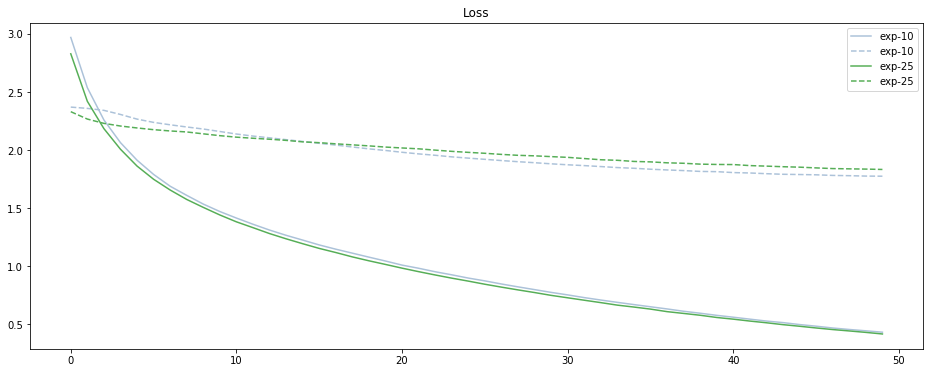

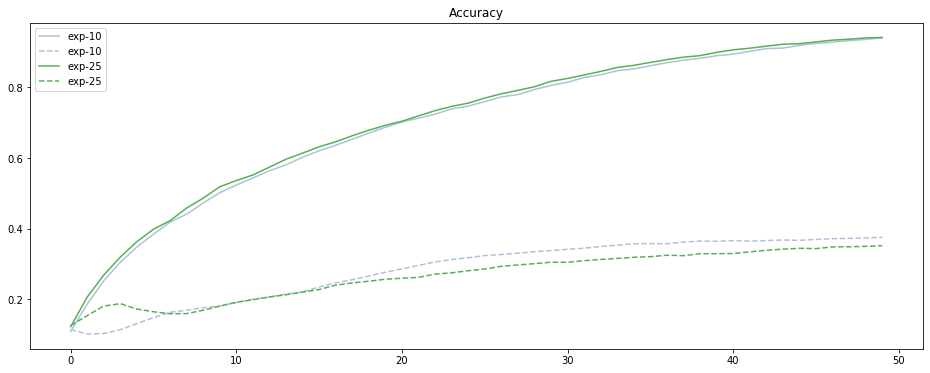

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
color_bar = list(colors._colors_full_map.values())

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()